In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.train.autoencoder import AutoEncoder, run_train, generate_new_signal
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset

In [2]:
# Data params
SAMPLE_SIZE = 1000
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0001


nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
PRINT_EACH = 100
VERBOSE = 1

dataset = SignalsDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
cuda = True if torch.cuda.is_available() else False
Z_dim = 100

class Generator(nn.Module):
    def __init__(self, x_dim, latent_dim=100):
        super(Generator, self).__init__()
        self.x_dim = x_dim
        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(self.x_dim)),
            nn.Tanh()
        )

    def forward(self, z):
        signal = self.model(z)
        return signal


class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super(Discriminator, self).__init__()
        self.x_dim = x_dim

        self.model = nn.Sequential(
            nn.Linear(self.x_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, signal):
        validity = self.model(signal)

        return validity

In [5]:
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(SAMPLE_SIZE)
discriminator = Discriminator(SAMPLE_SIZE)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

epoch-0; D_loss: 1.2012672424316406; G_loss: 0.40581706166267395


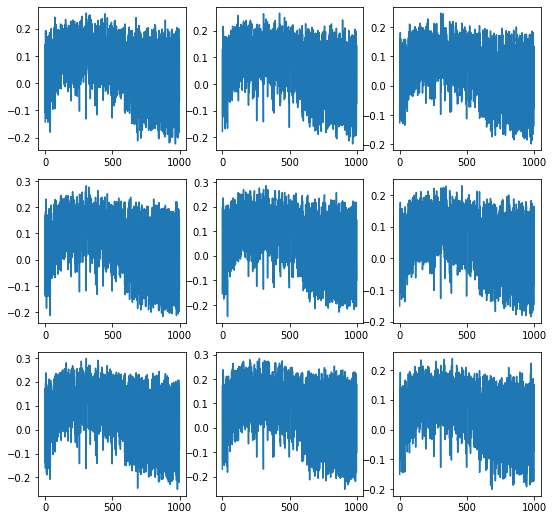

KeyboardInterrupt: 

In [10]:
ones_label = Variable(torch.ones(BATCH_SIZE, 1))
zeros_label = Variable(torch.zeros(BATCH_SIZE, 1))

for epoch in range(NUM_EPOCHS):
    for it, signal in enumerate(dataloader):
        if signal.shape[0] != BATCH_SIZE:
            break
            
        # Train Generator
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
        
        z = Variable(torch.randn(BATCH_SIZE, Z_dim))
        X = Variable(signal)
        G_sample = generator(z)
        D_fake = discriminator(G_sample)

        G_loss = F.binary_cross_entropy(D_fake, ones_label) #torch.norm(G_sample - torch.tensor(SAMPLE))# + torch.norm(G_sample - torch.tensor(sample))

        G_loss.backward(retain_graph=True)
        optimizer_G.step()
        
        # Train discriminator
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()

        D_real = discriminator(X)

        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        optimizer_D.step()

        # Print and plot every now and then
    if epoch % PRINT_EACH == 0:
        print('epoch-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))
#         print(G(z))
        samples = generator(z).data.numpy()[:9]
        f, ax = plt.subplots(3, 3, figsize=(9, 9))

        for i, sample in enumerate(samples):
            ax[i//3][i%3].plot(sample)
#             plt.plot(sample)

        plt.show()